<a href="https://colab.research.google.com/github/binhluong84/Machine-Learning/blob/main/Bacterial_Species_Prediction%2C_Fast_start%2C_EDA_%2B_PyTorch_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np # Linear algebra.
import pandas as pd # Data processing, CSV file I/O (e.g. pd.read_csv).

import datatable as dt # Data processing, CSV file I/O (e.g. dt.fread).

import seaborn as sns # Visualization.
import matplotlib.pyplot as plt # Visualization.

# Machine Learning block.
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder

import random
from tqdm import tqdm_notebook as tqdm
from collections import defaultdict
from copy import deepcopy
import warnings
warnings.filterwarnings('ignore')

print(f'\n[INFO] Libraries set up has been completed.')


[INFO] Libraries set up has been completed.


In [ ]:
!pip install datatable

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 96.9 MB 97 kB/s 


In [ ]:
#Connect Google Drive
from google.colab import drive
drive.mount('/gdrive')


Mounted at /gdrive


In [ ]:
%%time
df_train = dt.fread('/gdrive/MyDrive/Genetic_Analysis/train.csv').to_pandas()
df_test = dt.fread('/gdrive/MyDrive/Genetic_Analysis/test.csv').to_pandas()
df_sub = pd.read_csv('/gdrive/MyDrive/Genetic_Analysis/sample_submission.csv')

# Datatable reads target as bool by default.
mask_bool = df_train.dtypes == bool
bool_train = df_train.dtypes[mask_bool].index
bool_test = df_test.dtypes[mask_bool].index

df_train[bool_train] = df_train[bool_train].astype('int8')
df_test[bool_train] = df_test[bool_train].astype('int8')

df_train.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 288 entries, row_id to target
dtypes: float64(286), int32(1), object(1)
memory usage: 438.7+ MB
CPU times: user 9.76 s, sys: 3.76 s, total: 13.5 s
Wall time: 42.7 s


In [ ]:
miss_val_train =df_train.isna().any().sum()
miss_val_test = df_test.isna().any().sum()

print(f'\n[INFO] {miss_val_train} missing value(s) has/have been detected in the train dataset.')
print(f'[INFO] {miss_val_test} missing value(s) has/have been detected in the test dataset.')


[INFO] 0 missing value(s) has/have been detected in the train dataset.
[INFO] 0 missing value(s) has/have been detected in the test dataset.


In [ ]:
def reduce_mem_usage(df, verbose=True):
    start_mem = df.memory_usage().sum()/1024**2
    numerics = ['int8', 'int16', 'int32', 'int64',
                'float16', 'float32', 'float64']

    for col in df.columns:
        col_type = df[col].dtypes
        limit = abs(df[col]).max()

        for tp in numerics:
            cond1 = str(col_type)[0] == tp[0]
            if tp[0] == 'i': cond2 = limit <= np.iinfo(tp).max
            else: cond2 = limit <= np.finfo(tp).max

            if cond1 and cond2:
                df[col] = df[col].astype(tp)
                break

    end_mem = df.memory_usage().sum()/1024**2
    reduction = (start_mem - end_mem)*100/start_mem
    if verbose:
        print(f'[INFO] Mem. usage decreased to {end_mem:.2f}'
              f' MB {reduction:.2f}% reduction.')
    return df

target = df_train.target
df_train.drop(columns=['row_id', 'target'], inplace=True)
df_test.drop(columns='row_id', inplace=True)

df_train = reduce_mem_usage(df_train, verbose=True)
df_train['target'] = target
df_test = reduce_mem_usage(df_test, verbose=True)

print('\n')
df_train.head(5)

[INFO] Mem. usage decreased to 109.10 MB 75.00% reduction.
[INFO] Mem. usage decreased to 54.55 MB 75.00% reduction.




,A0T0G0C10,A0T0G1C9,A0T0G2C8,A0T0G3C7,A0T0G4C6,A0T0G5C5,A0T0G6C4,A0T0G7C3,A0T0G8C2,A0T0G9C1,...,A8T0G1C1,A8T0G2C0,A8T1G0C1,A8T1G1C0,A8T2G0C0,A9T0G0C1,A9T0G1C0,A9T1G0C0,A10T0G0C0,target
0,-9.536743e-07,-0.000010,-0.000043,-0.000114,-0.000200,-0.000240,-0.000200,-0.000114,-0.000043,-0.000010,...,-0.000086,-0.000043,-0.000086,-0.000086,-0.000043,-0.000010,-0.000010,-0.000010,-9.536743e-07,Streptococcus_pyogenes
1,-9.536743e-07,-0.000010,-0.000043,0.000885,-0.000200,0.000760,-0.000200,-0.000114,-0.000043,-0.000010,...,-0.000086,-0.000043,0.000914,0.000914,-0.000043,-0.000010,-0.000010,-0.000010,-9.536743e-07,Salmonella_enterica
2,-9.536743e-07,-0.000002,0.000007,0.000129,0.000268,0.000270,0.000243,0.000125,0.000001,-0.000007,...,0.000084,0.000048,0.000081,0.000106,0.000072,0.000010,0.000008,0.000019,1.072884e-06,Salmonella_enterica
3,5.960464e-08,-0.000006,0.000012,0.000245,0.000492,0.000522,0.000396,0.000197,-0.000003,-0.000007,...,0.000151,0.000100,0.000180,0.000202,0.000153,0.000021,0.000015,0.000046,-9.536743e-07,Salmonella_enterica
4,-9.536743e-07,-0.000010,-0.000043,-0.000114,-0.000200,-0.000240,-0.000200,-0.000114,-0.000043,-0.000010,...,-0.000086,-0.000043,-0.000086,-0.000086,-0.000043,-0.000010,-0.000010,-0.000010,-9.536743e-07,Enterococcus_hirae


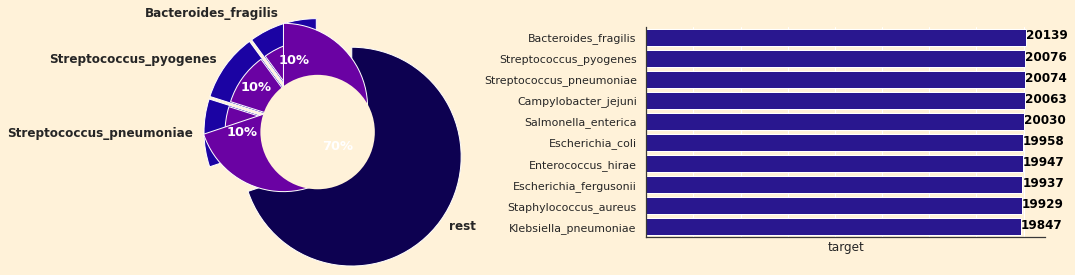

In [ ]:
rc = {
    "axes.facecolor":"#FFF2D9",
    "figure.facecolor":"#FFF2D9",
    "axes.edgecolor":"#383838",
    "axes.spines.right" : False,
    "axes.spines.top" : False,
}

sns.set(rc=rc)

df_target_count = df_train.target.value_counts()
s1 = df_target_count[:3]
s2 = pd.Series(sum(df_target_count[3:]), index=["rest"])
s3 = s1.append(s2)

f, axes = plt.subplots(ncols=2, figsize=(15, 4))
plt.subplots_adjust(wspace=0)

outer_sizes = s3
inner_sizes = s3/4
outer_colors = ['#1B03A3', '#1B03A3', '#1B03A3', '#0D0151']
inner_colors = ['#6A02A3', '#6A02A3', '#6A02A3']

axes[0].pie(
    outer_sizes,colors=outer_colors, 
    labels=s3.index.tolist(), 
    startangle=90,frame=True, radius=1.3, 
    explode=(.05,.05,.05,.5),
    wedgeprops={ 'linewidth' : 1, 'edgecolor' : 'white'}, 
    textprops={'fontsize': 12, 'weight': 'bold'}
)

textprops = {
    'size':13, 
    'weight': 'bold', 
    'color':'white'
}

axes[0].pie(
    inner_sizes, colors=inner_colors,
    radius=1, startangle=90,
    autopct='%1.f%%',explode=(.1,.1,.1, -.5),
    pctdistance=0.8, textprops=textprops
)

center_circle = plt.Circle((0,0), .68, color='black', 
                           fc='#FFF2D9', linewidth=0)
axes[0].add_artist(center_circle)

x = df_target_count
y = df_target_count.index.astype(str)
sns.barplot(
    x=x, y=y, ax=axes[1],
    color='#1B03A3', orient='horizontal'
)

axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].tick_params(
    axis='x',         
    which='both',      
    bottom=False,      
    labelbottom=False
)

for i, v in enumerate(df_target_count):
    axes[1].text(v, i+0.1, str(v), color='black', 
                 fontweight='bold', fontsize=12)
 
plt.tight_layout()    
plt.show()

In [ ]:
seed = 322
df_train_sample = df_train.sample(n=30000, random_state=seed)
df_test_sample = df_test.sample(n=30000, random_state=seed)

np.random.seed(seed) 
features_choice = np.random.choice(
    df_train_sample.keys()[1:-1], size=3, replace=False
)

mask = sorted(features_choice.tolist()) + ['target']
df_sample_three = df_train_sample[mask]
df_sample_three.head(3)

,A0T9G0C1,A2T3G0C5,A6T3G1C0,target
32344,0.000021,-0.000129,0.000638,Staphylococcus_aureus
136769,0.000086,-0.000188,0.000828,Enterococcus_hirae
6512,0.000090,-0.000523,0.002039,Streptococcus_pyogenes


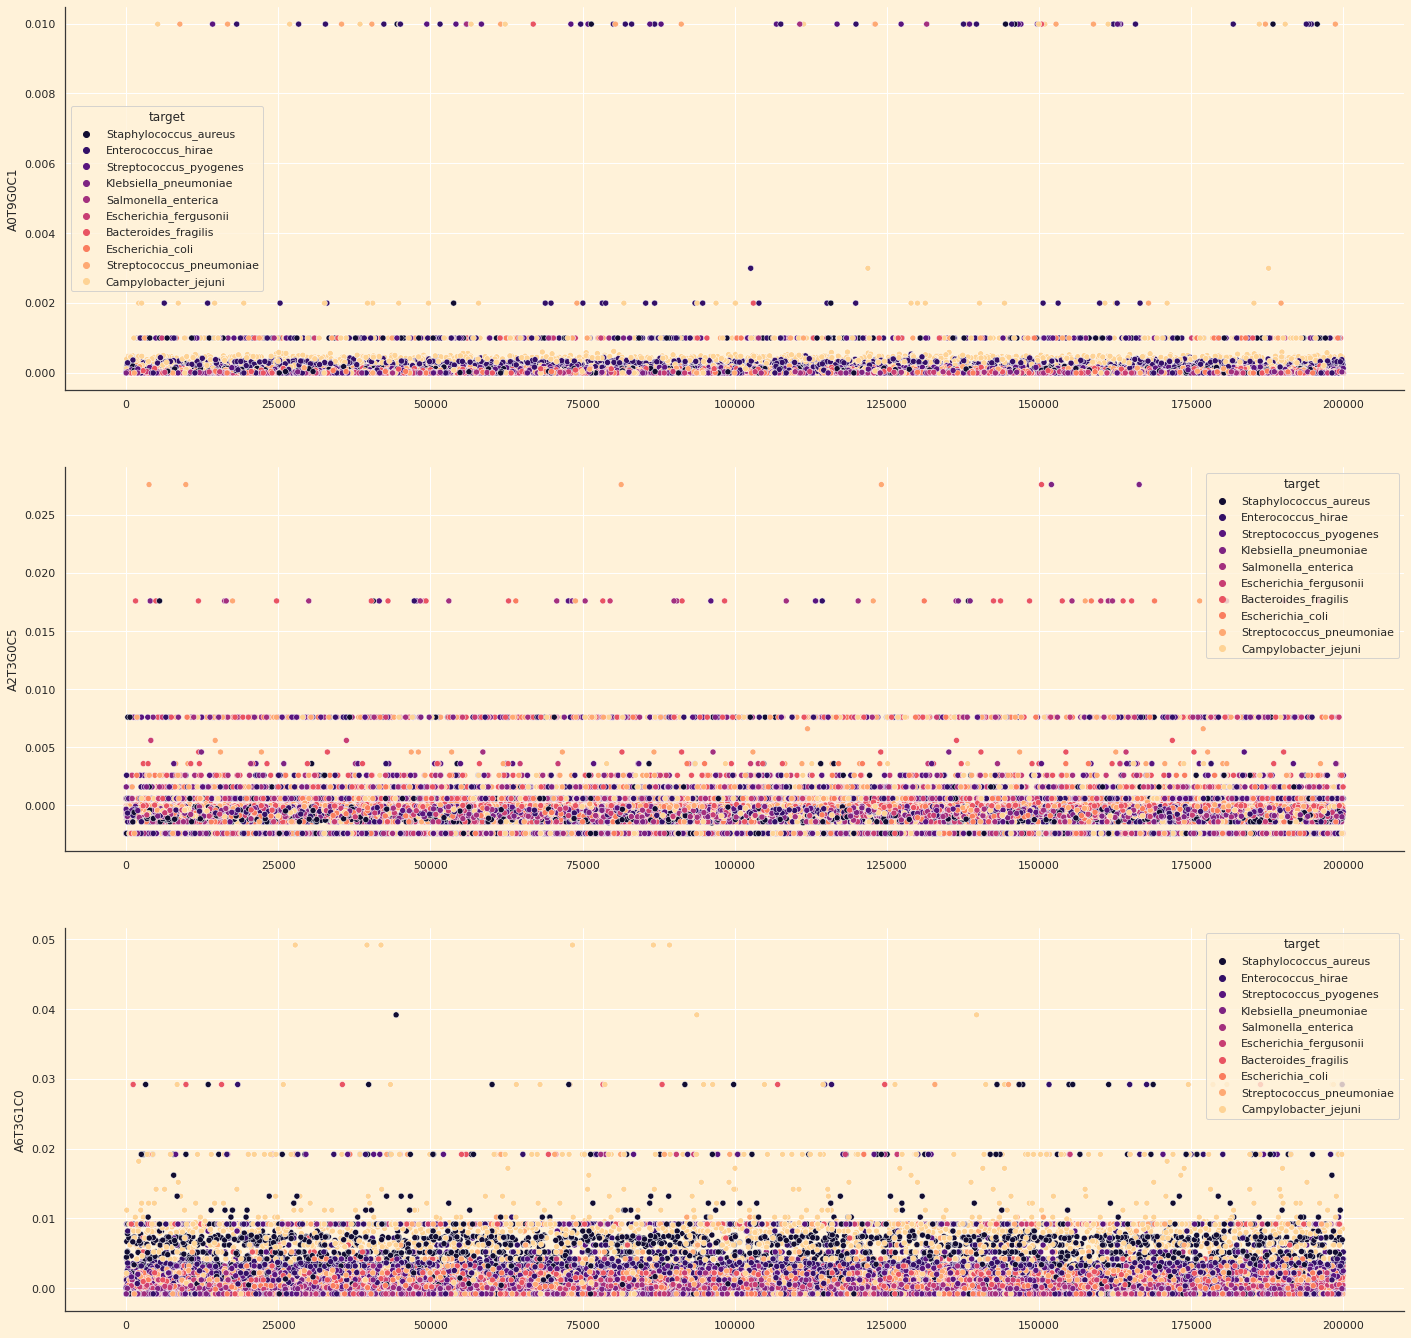

In [ ]:
fig, ax = plt.subplots(nrows=3, figsize=(24, 24))

for i, feature in enumerate(sorted(features_choice)):
     sns.scatterplot(
         ax=ax[i], x=df_sample_three.index,
         y=feature,data=df_sample_three,
         hue='target',palette='magma',
         legend=True,
     )

In [ ]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
descr_tr = df_train.iloc[:, :-1].describe().T\
                     .sort_values(by='std', ascending=False)


pd.concat([descr_tr.iloc[:5,:], descr_tr.iloc[-5:,:]])\
                     .style.background_gradient(cmap='magma')\
                     .bar(subset=["mean",], color='green')\
                     .bar(subset=["max"], color='#BB0000')

,count,mean,std,min,25%,50%,75%,max
A0T0G0C10,200000.000000,0.000000,0.000000,-0.000001,-0.000001,-0.000001,-0.000001,0.010002
A3T3G1C3,200000.000000,-0.000000,0.000000,-0.016022,-0.003021,-0.000406,0.001493,0.083984
A3T4G2C1,200000.000000,0.000000,0.000000,-0.012016,-0.001976,0.001770,0.007973,0.088013
A3T4G1C2,200000.000000,0.000000,0.000000,-0.012016,-0.003016,-0.000466,0.005215,0.078003
A3T4G0C3,200000.000000,0.000000,0.000000,-0.004005,-0.002005,-0.000041,0.002464,0.056000
A1T4G1C4,200000.000000,-0.000000,0.000000,-0.006008,-0.002008,-0.000338,0.000711,0.033997
A1T4G2C3,200000.000000,-0.000000,0.000000,-0.012016,-0.004017,-0.001809,-0.000052,0.047974
A1T4G3C2,200000.000000,-0.000000,0.000000,-0.012016,-0.003016,-0.001234,0.000209,0.037994
A1T4G4C1,200000.000000,-0.000000,0.000000,-0.006008,-0.002249,-0.000878,-0.000098,0.033997
A10T0G0C0,200000.000000,0.000000,0.000000,-0.000001,-0.000001,-0.000001,-0.000001,0.000999


In [ ]:
descr_ts = df_test.describe().T\
                     .sort_values(by='std', ascending=False)


pd.concat([descr_ts.iloc[:5,:], descr_ts.iloc[-5:,:]])\
                     .style.background_gradient(cmap='magma')\
                     .bar(subset=["mean",], color='green')\
                     .bar(subset=["max"], color='#BB0000')

,count,mean,std,min,25%,50%,75%,max
A0T0G0C10,100000.000000,0.000000,0.000000,-0.000001,-0.000001,-0.000001,-0.000001,0.010002
A3T3G1C3,100000.000000,-0.000000,0.000000,-0.016022,-0.003021,-0.000392,0.001478,0.073975
A3T4G2C1,100000.000000,0.000000,0.000000,-0.012016,-0.001856,0.001791,0.007725,0.088013
A3T4G1C2,100000.000000,0.000000,0.000000,-0.012016,-0.003016,-0.000426,0.005226,0.088013
A3T4G0C3,100000.000000,0.000000,0.000000,-0.004005,-0.002005,-0.000038,0.002485,0.035980
A1T4G1C4,100000.000000,-0.000000,0.000000,-0.006008,-0.002008,-0.000347,0.000692,0.023987
A1T4G2C3,100000.000000,-0.000000,0.000000,-0.012016,-0.004017,-0.001726,-0.000035,0.047974
A1T4G3C2,100000.000000,-0.000000,0.000000,-0.012016,-0.003016,-0.001266,0.000134,0.047974
A1T4G4C1,100000.000000,-0.000000,0.000000,-0.006008,-0.002338,-0.000888,-0.000136,0.044006
A10T0G0C0,100000.000000,-0.000000,0.000000,-0.000001,-0.000001,-0.000001,-0.000001,0.000999


Let's take a closer look at the distribution of the features:

AttributeError: ignored

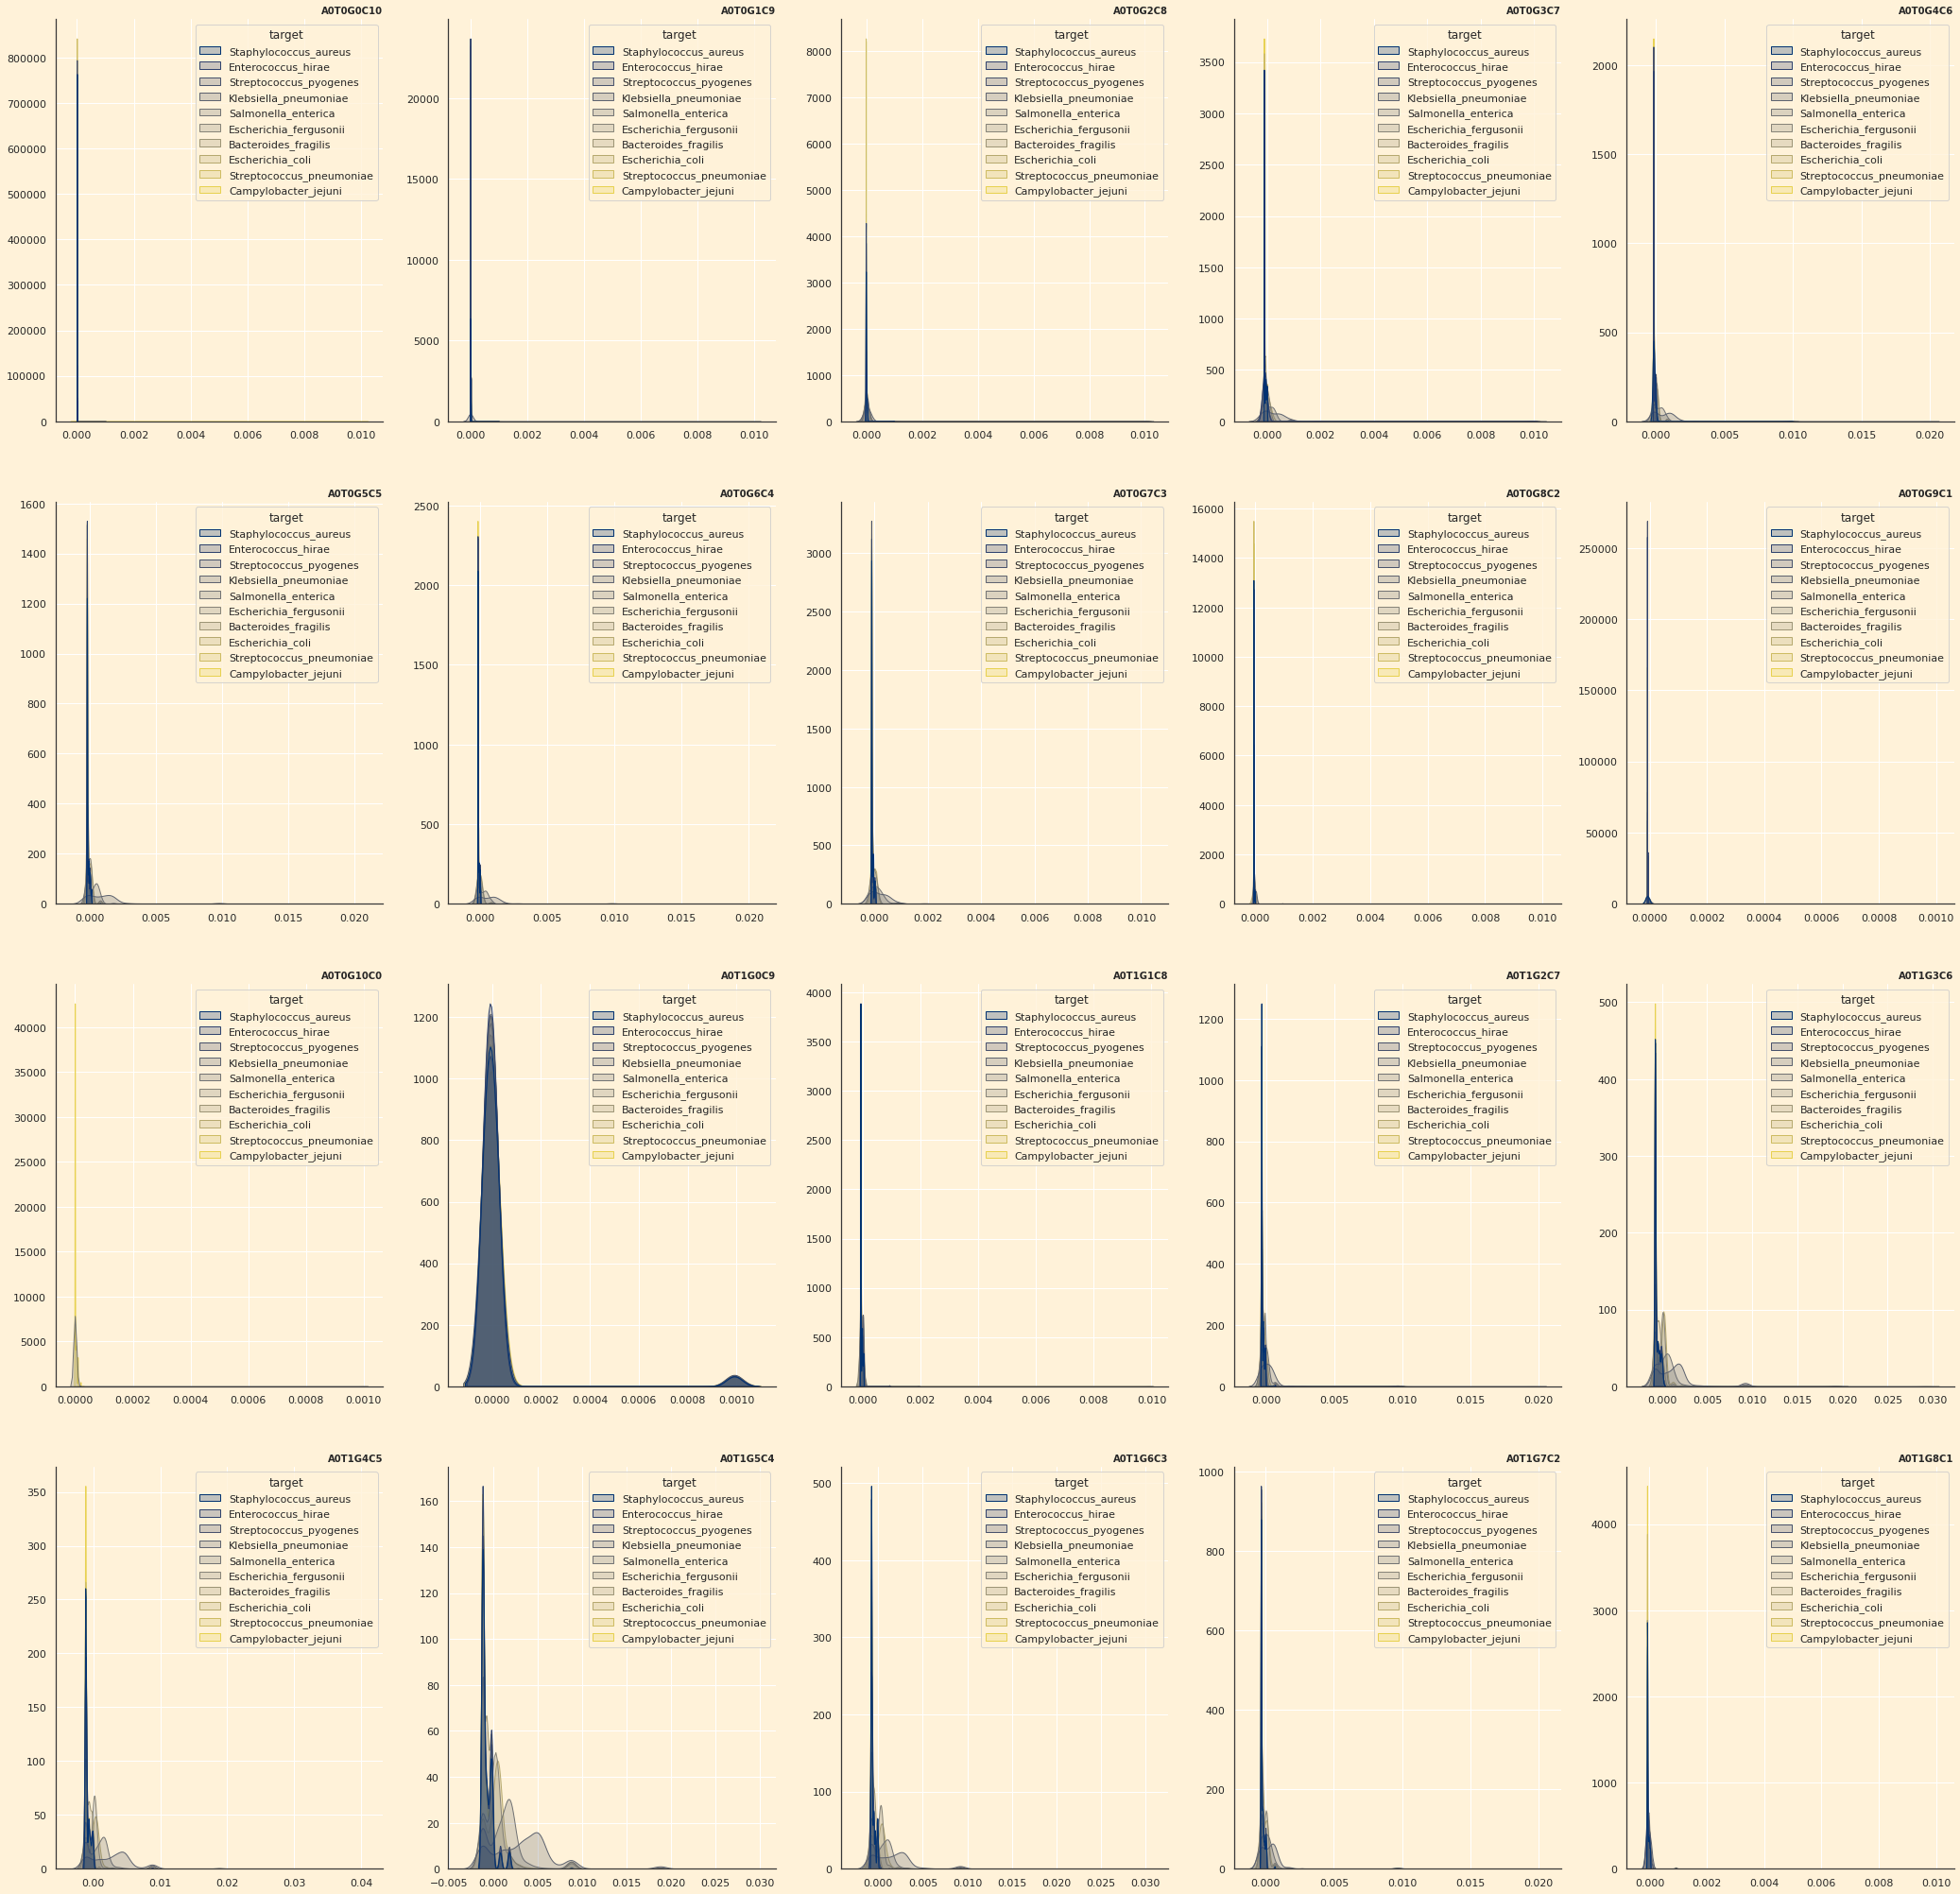

In [ ]:
%%time
figsize = (6*6, 6*6)
fig = plt.figure(figsize=figsize)
title = 'Probability Density Function Estimation'
for idx, col in enumerate(df_test.columns[:20]):
    ax = plt.subplot(4, 5, idx + 1)
    sns.kdeplot(
        data=df_train_sample, hue='target', fill=True,
        x=col, palette='cividis'
    )
            
    ax.set_ylabel(''); ax.spines['top'].set_visible(False), 
    ax.set_xlabel(''); ax.spines['right'].set_visible(False)
    ax.set_title(f'{col}', loc='right', 
                 weight='bold', fontsize=10)

fig.supxlabel(f'\n\n{title} Train\n\n', ha='center', 
              fontweight='bold', fontsize=30)
plt.tight_layout()
plt.show()

fig = plt.figure(figsize=figsize)
for idx, col in enumerate(df_test.columns[:20]):
    ax = plt.subplot(4, 5, idx + 1)
    sns.kdeplot(
    data=df_train_sample, fill=True,
    x=col, color='#1B03A3', label='Train'
    )
    sns.kdeplot(
        data=df_test_sample, fill=False,
        x=col, color='#E54232', label='Test'
    )

    ax.set_xticks([]); ax.set_xlabel(''); 
    ax.set_ylabel(''); ax.spines['right'].set_visible(False)
    ax.set_yticks([]); ax.spines['top'].set_visible(False)
    ax.set_title(f'{col}', loc='right', 
                 weight='bold', fontsize=10)
    
fig.supxlabel(f'\n\n{title} Train vs Test set', ha='center', 
              fontweight='bold', fontsize=30)
       
plt.tight_layout()
plt.show()

We have plotted Probability Density Function estimation for each feature. What does it tell us?

The features are distributed differently;
The data is not perfectly symmetrical. The most of the features right-skewed.
There is no bell-shaped-like (e.g., Gaussian distribution) plots.
The plot supports the assumption that the train and test data are from the same distribution.
Let's us take a look at features correlation matrix:

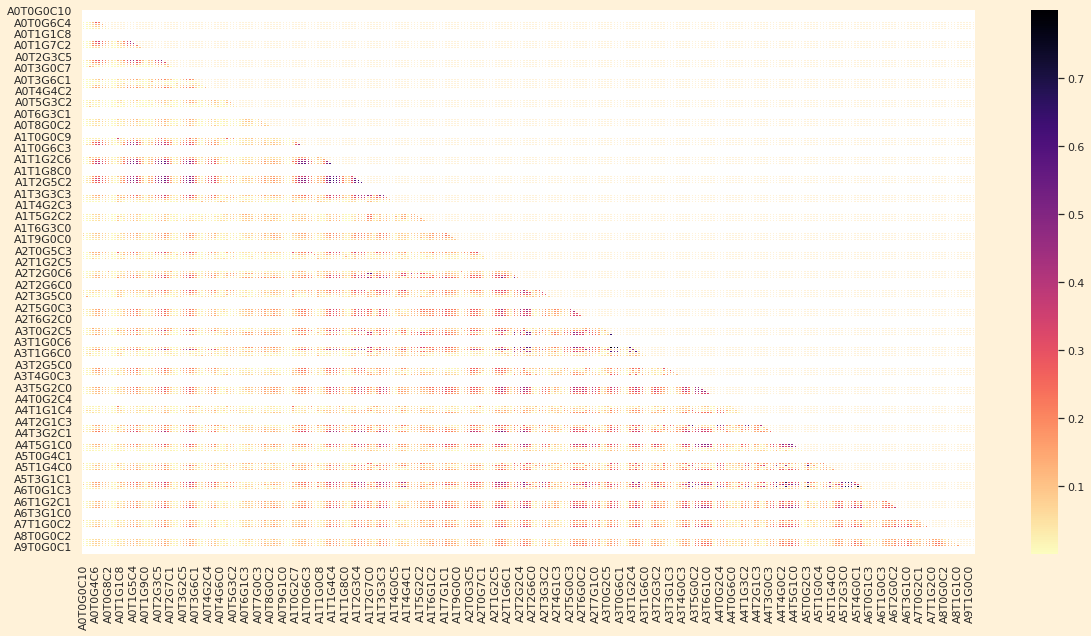

In [ ]:
corr_ = df_train_sample.corr().abs()

fig, axes = plt.subplots(figsize=(20, 10))
mask1 = np.zeros_like(corr_)
mask1[np.triu_indices_from(mask1)] = True
sns.heatmap(corr_, mask=mask1, linewidths=.5, cmap='magma_r')

plt.show()

If we wish to label the strength of the features association, for absolute values of correlation, 0-0.19 is regarded as very weak (the most of our examples are: [0.00-0.20].

Let's zoom in and take a closer look at the highly correlated pairs of features, taking an arbitrary threshold of correlation as 0.7:

In [ ]:
# Fill df diagonal with zeros
np.fill_diagonal(corr_.values, 0)
pivot = corr_.unstack()
corr_pairs = pivot.sort_values(kind="quicksort", ascending=False)
high_corr_pairs = corr_pairs[corr_pairs > .7]
pd.DataFrame(high_corr_pairs[::2], columns=['corr']).head(3)

,,corr
A1T2G6C1,A1T2G7C0,0.80
A4T1G4C1,A4T0G1C5,0.80
A3T1G3C3,A3T0G3C4,0.80


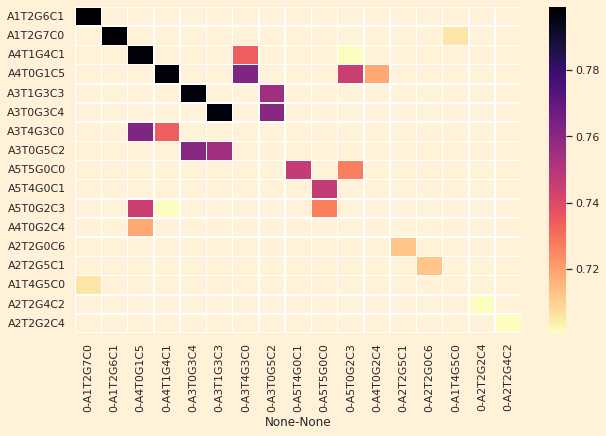

In [ ]:
fig, axes = plt.subplots(figsize=(10, 6))
df_hcorr_pairs = pd.DataFrame(high_corr_pairs).unstack()
sns.heatmap(df_hcorr_pairs, linewidths=.5, cmap='magma_r')
plt.show()

Feature engineering refers to the process of using domain knowledge to select and transform the most relevant variables from raw data.

One of the naive approach to engineer features, is to aggregate them.

The problem with aggregation is that we might encounter multicollinearity (e.g., the high correlation of the explanatory variables). "It should be noted that the presence of multicollinearity does not mean that the model is misspecified. You only start to talk about it when you think that it is affecting the regression results seriously." [1]

In [ ]:
agg_features = ['sum','mean','std','max','min']
features = df_test.columns
for ft in agg_features:
    
    class_method = getattr(pd.DataFrame, ft)
    df_train_sample[ft] = class_method(df_train_sample[features], axis=1)
    df_test_sample[ft] = class_method(df_test_sample[features], axis=1)

df_test_sample.head(3)

,A0T0G0C10,A0T0G1C9,A0T0G2C8,A0T0G3C7,A0T0G4C6,A0T0G5C5,A0T0G6C4,A0T0G7C3,A0T0G8C2,A0T0G9C1,...,A8T2G0C0,A9T0G0C1,A9T0G1C0,A9T1G0C0,A10T0G0C0,sum,mean,std,max,min
27865,-0.00,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,...,-0.00,0.00,0.00,-0.00,-0.00,-0.00,-0.00,0.00,0.00,-0.00
97358,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,...,0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,0.00,0.00,-0.01
92546,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,...,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.01,0.03,-0.02


In [ ]:
pairs = pd.DataFrame(high_corr_pairs[::2], columns=['corr'])
pairs

,,corr
A1T2G6C1,A1T2G7C0,0.80
A4T1G4C1,A4T0G1C5,0.80
A3T1G3C3,A3T0G3C4,0.80
A3T4G3C0,A4T0G1C5,0.76
A3T0G5C2,A3T0G3C4,0.76
A3T1G3C3,A3T0G5C2,0.75
A5T5G0C0,A5T4G0C1,0.75
A5T0G2C3,A4T0G1C5,0.75
A4T1G4C1,A3T4G3C0,0.73
A5T5G0C0,A5T0G2C3,0.73


In [ ]:
def stack_elimination(train, test, pairs, elim=False):
    """

    Creates combined mean feature based on the pair.
    Takes highly correlated feature pairs and eliminate them.
    
    :param train: (pd.DataFrame)
    :param test: (pd.DataFrame)
    :param pairs: (multiIndex pd.Dataframe)
    :param elim: bool
    :return: train (pd.DataFrame), test (pd.DataFrame)
    """
    
    
    for i, pair in enumerate(pairs.index): 
        
       
        # Creates combined mean feature.
        train[f'pair{i}'] = train[list(pair)].mean(axis=1)
        test[f'pair{i}'] = test[list(pair)].mean(axis=1)

    if elim:
        # Eliminates the paired features.       
        flat_pairs_list = [j for i in pairs.index for j in i]
        ft_train = train.columns
        ft_test = test.columns
        diff_train = set(ft_train).difference(flat_pairs_list)
        diff_test = set(ft_test).difference(flat_pairs_list)
        train = train[sorted(diff_train)]
        test = test[sorted(diff_test)]
        
    return train, test

train, test = stack_elimination(df_train_sample, df_test_sample, pairs)
train.head(3)

,A0T0G0C10,A0T0G1C9,A0T0G2C8,A0T0G3C7,A0T0G4C6,A0T0G5C5,A0T0G6C4,A0T0G7C3,A0T0G8C2,A0T0G9C1,...,pair5,pair6,pair7,pair8,pair9,pair10,pair11,pair12,pair13,pair14
32344,0.00,0.00,0.00,-0.00,0.00,-0.00,-0.00,0.00,0.00,-0.00,...,-0.00,0.00,-0.00,0.00,0.00,-0.00,-0.00,-0.00,-0.00,-0.00
136769,0.00,0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,...,-0.00,0.00,-0.00,0.00,0.00,-0.00,-0.00,-0.00,-0.00,-0.00
6512,-0.00,0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,...,-0.00,0.00,-0.00,0.00,0.00,-0.00,-0.00,-0.00,-0.01,-0.00


5. PyTorch NN Model

Versions notes:

Version1: Model hidden layers + Batch_Norm [300, BN, 200, BN, 100, BN, 50 BN].
Things to try:

Feature Engineering.
Add evaluation plots and confusion matrices.

In [ ]:
train_csv_path = '/gdrive/MyDrive/Genetic_Analysis/train.csv'
test_csv_path = '/gdrive/MyDrive/Genetic_Analysis/test.csv'

train = dt.fread(train_csv_path).to_pandas()
test = dt.fread(test_csv_path).to_pandas()

# Encode target labels with value between 0 and n_classes.
le = LabelEncoder()
target = le.fit_transform(train.target)

col_drop=['row_id']    
if col_drop:
    train.drop(columns=col_drop, inplace=True)
    test.drop(columns=col_drop, inplace=True)
    print(f'\n[INFO] "Id" columns have been removed successfully.\n')

# Applies encoded target.
train = train.iloc[:, :-1]
train['target'] = target
train.head()


[INFO] "Id" columns have been removed successfully.



,A0T0G0C10,A0T0G1C9,A0T0G2C8,A0T0G3C7,A0T0G4C6,A0T0G5C5,A0T0G6C4,A0T0G7C3,A0T0G8C2,A0T0G9C1,...,A8T0G1C1,A8T0G2C0,A8T1G0C1,A8T1G1C0,A8T2G0C0,A9T0G0C1,A9T0G1C0,A9T1G0C0,A10T0G0C0,target
0,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,...,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,9
1,-0.00,-0.00,-0.00,0.00,-0.00,0.00,-0.00,-0.00,-0.00,-0.00,...,-0.00,-0.00,0.00,0.00,-0.00,-0.00,-0.00,-0.00,-0.00,6
2,-0.00,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,6
3,0.00,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.00,6
4,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,...,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,2


In [ ]:
class TabularDataset(Dataset):
    def __init__(self, x, y):
        """
        Defines PyTorch dataset.
        :param x: np.ndarray
        :param y: np.ndarray
        """

        self.len = x.shape[0]
        self.x = torch.Tensor(x).float()
        self.y = torch.LongTensor(y).long().flatten()

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

    def __len__(self):
        return self.len

5.3 Model and weights initialization

In [ ]:
class Model(nn.Module):
    def __init__(self, in_features, num_cls):
        super().__init__()

        self.fc1 = nn.Linear(in_features, 300)
        self.bn1 = nn.BatchNorm1d(300)
        self.fc2 = nn.Linear(300, 200)
        self.bn2 = nn.BatchNorm1d(200)
        self.fc3 = nn.Linear(200, 100)
        self.bn3 = nn.BatchNorm1d(100)
        self.fc4 = nn.Linear(100, 50)
        self.bn4 = nn.BatchNorm1d(50)
        self.fc_out = nn.Linear(50, num_cls)

        self.activation = nn.ReLU()
        self.classifier = nn.Sigmoid()

    def forward(self, x):

        x = self.activation(self.fc1(x))
        x = self.bn1(x)
        x = self.activation(self.fc2(x))
        x = self.bn2(x)
        x = self.activation(self.fc3(x))
        x = self.bn3(x)
        x = self.activation(self.fc4(x))
        x = self.bn4(x)
        x = self.fc_out(x)

        return x

def init_weights(layer):
    if isinstance(layer, nn.Linear):
        nn.init.xavier_normal_(layer.weight.data)

5.4 Device and model summary

In [ ]:
train.iloc[:, :-1].shape[1]

286

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[INFO] Available device: {device}.\n\n")

n_ft = train.iloc[:, :-1].shape[1]
n_cls = len(set(target))
model = Model(in_features=n_ft, num_cls=n_cls).to(torch.device(device))

try:
    from torchsummary import summary
except:
    print("Installing Torchsummary..........")
    ! pip install torchsummary -q
    from torchsummary import summary
    
summary(model, (n_ft,))

[INFO] Available device: cpu.


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 300]          86,100
              ReLU-2                  [-1, 300]               0
       BatchNorm1d-3                  [-1, 300]             600
            Linear-4                  [-1, 200]          60,200
              ReLU-5                  [-1, 200]               0
       BatchNorm1d-6                  [-1, 200]             400
            Linear-7                  [-1, 100]          20,100
              ReLU-8                  [-1, 100]               0
       BatchNorm1d-9                  [-1, 100]             200
           Linear-10                   [-1, 50]           5,050
             ReLU-11                   [-1, 50]               0
      BatchNorm1d-12                   [-1, 50]             100
           Linear-13                   [-1, 10]             510
Total p

5.5 Utils

In [ ]:
def accuracy(output, target, topk=(1,)):
    """
    Computes the precision@k for the specified values of k
    """
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res


class MetricMonitor:
    def __init__(self, float_precision=3):
        self.float_precision = float_precision
        self.reset()

    def reset(self):
        self.metrics = defaultdict(lambda: {"val": 0, "count": 0, "avg": 0})

    def update(self, metric_name, val):
        metric = self.metrics[metric_name]

        metric["val"] += val
        metric["count"] += 1
        metric["avg"] = metric["val"] / metric["count"]

    def __str__(self):
        return " | ".join(
            [
                "{metric_name}: {avg:.{float_precision}f}".format(
                    metric_name=metric_name, avg=metric["avg"], float_precision=self.float_precision
                )
                for (metric_name, metric) in self.metrics.items()
            ]
        )


def set_seed(seed):
    """
    Fixes seed for the reproducible results.
    """

    random.seed(seed)
    np.random.seed(seed)

    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

5.6 Train and valid loops with tqdm bar

In [ ]:
def train_loop(train_loader, model, criterion, optimizer, epoch, device):
    metric_monitor = MetricMonitor()
    model.train()
    stream = tqdm(train_loader)
    for i, (x, y) in enumerate(stream, start=1):
        features = x.to(device)
        target = y.to(device)
        output = model(features)
        loss = criterion(output, target)
        acc_train = accuracy(output, target)
        metric_monitor.update("Loss", loss.item())
        metric_monitor.update("Accuracy", acc_train[0].item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        desc = "Epoch: {epoch}. Train.      {metric_monitor}"
        stream.set_description(
          desc.format(epoch=epoch, metric_monitor=metric_monitor)
        )
    
    loss_avg = metric_monitor.metrics["Loss"]['avg']
    acc_avg = metric_monitor.metrics["Accuracy"]['avg']

    return loss_avg, acc_avg


def val_loop(val_loader, model, criterion, epoch, device):
    metric_monitor = MetricMonitor()
    model.eval()
    stream = tqdm(val_loader)
    with torch.no_grad():
        for i, (x, y) in enumerate(stream, start=1):
            features = x.to(device)
            target = y.to(device)
            output = model(features)
            loss = criterion(output, target)
            acc_val = accuracy(output, target)

            metric_monitor.update("Loss", loss.item())
            metric_monitor.update("Accuracy", acc_val[0].item())
            desc = "Epoch: {epoch}. Validation.      {metric_monitor}"
            stream.set_description(
                desc.format(epoch=epoch, metric_monitor=metric_monitor)
            )
            
    loss_avg = metric_monitor.metrics["Loss"]['avg']
    acc_avg = metric_monitor.metrics["Accuracy"]['avg']

    return loss_avg, acc_avg

In [ ]:
param = {
        'seed': 1,
        'nfold': 10,
        'lr': 9e-5,
        'wd': 1e-5,
        'plateau_factor': .5,
        'plateau_patience': 4,
        'batch': 1024,
        'epochs': 40,
        'early_stopping': 9
    }

5.8 Training Main

In [ ]:
n_ft = train.iloc[:, :-1].shape[1]
n_cls = len(set(target))

X = train.iloc[:, :-1].values
y = train.iloc[:, -1:].values

# StratifiedKfold data split.
skf = StratifiedKFold(
    n_splits=param['nfold'],
    shuffle=True,
    random_state=param['seed']
)
    

for fold, (idx_train, idx_val) in enumerate(skf.split(X, y)):
    
    if fold == 1:
        break
    # Model, weights and seed init.
    model = Model(in_features=n_ft, num_cls=n_cls)
    model.apply(init_weights)
    model = model.to(torch.device(device))
    set_seed(param['seed'])

    # Loss and optimizer.
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(
        model.parameters(),
        lr=param['lr'],
        weight_decay=param['wd']
    )

    scheduler = ReduceLROnPlateau(
                optimizer=optimizer,
                factor=param['plateau_factor'],
                patience=param['plateau_patience'],
                mode='max', verbose=True
            )
    
   
    scaler = StandardScaler()
    X_train, y_train = scaler.fit_transform(X[idx_train, :]), y[idx_train]
    X_val, y_val = scaler.transform(X[idx_val, :]), y[idx_val]
    print(
        f'\n[INFO] Fold: {fold+1}, '
        f'X_train shape: {X_train.shape}, '
        f'X_val shape: {X_val.shape}.\n'
    )

    trainset = TabularDataset(X_train, y_train)
    valset = TabularDataset(X_val, y_val)
    train_loader = DataLoader(trainset, batch_size=param['batch'], shuffle=True)
    val_loader = DataLoader(valset, batch_size=param['batch'], shuffle=True)
    wait_counter = 0
    valid_acc_best = 0
    
    for epoch in range(1, param['epochs'] + 1):
        train_loss, train_acc = train_loop(train_loader, model, criterion, optimizer, epoch, device)
        valid_loss, valid_acc = val_loop(val_loader, model, criterion, epoch, device)
        
        if valid_acc > valid_acc_best:
            valid_acc_best = valid_acc
            wait_counter = 0
            best_model = deepcopy(model)
            print(f'\n[INFO] The best model has been saved.\n')
        else:
            wait_counter += 1
            if wait_counter > param['early_stopping']:
                print(f"\n[INFO] There's been no improvement "
                      f"in val_acc. Early stopping has been invoked.")
                break


[INFO] Fold: 1, X_train shape: (180000, 286), X_val shape: (20000, 286).



  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


[INFO] The best model has been saved.



  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


[INFO] The best model has been saved.



  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


[INFO] The best model has been saved.



  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


[INFO] The best model has been saved.



  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


[INFO] The best model has been saved.



  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


[INFO] The best model has been saved.



  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


[INFO] The best model has been saved.



  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


[INFO] The best model has been saved.



  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


[INFO] The best model has been saved.



  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


[INFO] The best model has been saved.



  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


[INFO] The best model has been saved.



  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


[INFO] The best model has been saved.



  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


[INFO] The best model has been saved.



  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


[INFO] The best model has been saved.



  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


[INFO] The best model has been saved.



  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


[INFO] The best model has been saved.



  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


[INFO] The best model has been saved.



  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


[INFO] The best model has been saved.



  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


[INFO] The best model has been saved.



  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


[INFO] The best model has been saved.



  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


[INFO] The best model has been saved.



  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


[INFO] The best model has been saved.



  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


[INFO] The best model has been saved.



  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


[INFO] The best model has been saved.



  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


[INFO] The best model has been saved.



  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


[INFO] The best model has been saved.



  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


[INFO] The best model has been saved.



  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


[INFO] The best model has been saved.



  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


[INFO] The best model has been saved.



  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


[INFO] The best model has been saved.



In [ ]:
X_test = scaler.transform(test)
testset = TabularDataset(X_test, np.ones((X_test.shape[0], 1)))
test_loader = DataLoader(testset, batch_size=1024)
y_pred_list = []

best_model.eval()
with torch.no_grad():
    for X_batch, _ in tqdm(test_loader):
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch.float())
        _, y_pred_tags = torch.max(y_test_pred, dim=1)
        y_pred_list.extend(y_pred_tags.cpu().numpy())


# Rearranges classes back (e.g. [0,1,2,3,4,5] -> arr of strings;
# Creates mapped test_y preds list.
test_y = le.inverse_transform(y_pred_list)
            
df_sub['target'] = test_y
df_sub.to_csv('submission.csv', index=False)
df_sub  

  0%|          | 0/98 [00:00<?, ?it/s]

,row_id,target
0,200000,Escherichia_fergusonii
1,200001,Salmonella_enterica
2,200002,Enterococcus_hirae
3,200003,Salmonella_enterica
4,200004,Staphylococcus_aureus
...,...,...
99995,299995,Streptococcus_pneumoniae
99996,299996,Bacteroides_fragilis
99997,299997,Bacteroides_fragilis
99998,299998,Bacteroides_fragilis
